__File: src_physics_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Apr 09, 2021__

Generates SRC physics figures. Use this notebook in conjunction with data files generated by src_physics_write_data.ipynb.

__Revision history:<br/>__
* Apr 13, 2021 - Finished the following functions: n_lambda_deuteron_decomposition, srg_transformation_partial_wave_ratios, snmd_tails, pp_pn_pmd_ratios, p_n_pmd_ratios, and a2_scaling_factors.
* Apr 15, 2021 - Adding experimental $a_2$ values to a2_scaling_factors figures.

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff

In [2]:
# Save figures in the following directory (you can change this in the Dropbox)
figure_directory = 'Figures/SRC_physics'

In [3]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """
    # Changes by A.T.
    # I'm going to set the x- and y-axis label sizes within the plotting functions not here
    # Also going to deal with the legend for each figure individually
    
    if presentation:
        fontsize = 11
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by AJT
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    # Make axes tick marks appear on all sides of the figure!

    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
#     mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
#     mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
#     mpl.rcParams['legend.fancybox'] = True
#     mpl.rcParams['legend.borderaxespad'] = 0.8
#     mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
#     mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

#     mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [4]:
# Run this cell to customize matplotlib graphics (see setup_rc_params for details)

setup_rc_params(presentation=True)
# setup_rc_params(presentation=False)

__Decomposition of $n^{\lambda}_d(q)$__

In [5]:
def n_lambda_deuteron_decomposition(kvnn, lamb, kmax=10.0, kmid=2.0, ntot=120, curves=4, xlim=(0, 4), ylim=(1e-5, 1e3)):
    """
    SRG-evolved deuteron pair momentum distribution as calculated by our expansion of U(k, k') in second
    quantization using deuteron wave function (not LDA). Gives each of the contributions from 1, \delta U,
    \delta U \delta U^\dagger.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    curves : int
        Number of curves to be plotted starting with the full high-resolution result, then the 1 term, \delta U,
        term, and finally \delta U \delta U^{\dagger} term.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3]. If ylim[0] <= 0, plots on a linear y-scale.
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Make sure the number of curves makes sense
    # Can only go from 1 to 4
    if not ( curves in range(1, 5) ):
        print('Invalid number of curves. Must specify an integer from 1-4.')
        return None
    
    # Load data from the following directory
    data_directory = 'Figures/SRC_physics/Data'

    # Data file name
    file_name = 'n_lambda_deuteron_decomposition_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
    file_name = ff.replace_periods(file_name) + '.dat'
    
    # Load momentum and momentum distribution contributions for given potential
    data = np.loadtxt(data_directory + '/' + file_name)
    q_array = data[:, 0] # Momentum in fm^-1
    n_d_total_array = data[:, 1] # Total momentum distribution in fm^3
    n_d_1_array = data[:, 2] # Contribution from 1 term
    n_d_deltaU_array = data[:, 3] # Contribution from \delta U term
    n_d_deltaU2_array = data[:, 4] # Contribution from \delta U^2 term
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n^{\lambda}_d(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 18
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Linear scale
    if ylim[0] <= 0.0:
        
        # Plot total
        ax.plot(q_array, n_d_total_array, color='xkcd:black', label='High res.', linestyle='solid',
                    linewidth=curve_width)
        # Plot 1 term
        if curves > 1:
            ax.plot(q_array, n_d_1_array, color='xkcd:blue', label='1', linestyle='dotted', linewidth=curve_width)
        # Plot \delta U term
        if curves > 2:
            ax.plot(q_array, n_d_deltaU_array, color='xkcd:green', label=r'$\delta U$', linestyle='dashed',
                    linewidth=curve_width)
        # Plot \delta U^2 term
        if curves > 3:
            ax.plot(q_array, n_d_deltaU2_array, color='xkcd:red', label=r'$\delta U \delta U^{\dagger}$',
                    linestyle='dashdot', linewidth=curve_width)        
        
    # Log scale
    else:
        
        ax.semilogy(q_array, n_d_total_array, color='xkcd:black', label='High res.', linestyle='solid',
                    linewidth=curve_width)
        # Plot 1 term
        if curves > 1:
            ax.semilogy(q_array, n_d_1_array, color='xkcd:blue', label='1', linestyle='dotted', linewidth=curve_width)
        # Plot \delta U term (take absolute value!)
        if curves > 2:
            ax.semilogy(q_array, abs(n_d_deltaU_array), color='xkcd:green', label=r'$|\delta U|$', linestyle='dashed',
                        linewidth=curve_width)
        # Plot \delta U^2 term (take absolute value!)
        if curves > 3:
            ax.semilogy(q_array, abs(n_d_deltaU2_array), color='xkcd:red', label=r'$|\delta U \delta U^{\dagger}|$',
                        linestyle='dashdot', linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [6]:
# # Deuteron pair momentum distribution contributions for AV18 with \lambda=1.35 fm^-1

# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# curves_tuple = (1, 2, 3, 4)
# xlim = (0, 4)
# ylim = (1e-5, 1e3) # Log-scale y-axis

# # Loop over the number of contributions you want showing on the figure
# for curves in curves_tuple:
    
#     f, ax = n_lambda_deuteron_decomposition(kvnn, lamb, kmax, kmid, ntot, curves, xlim, ylim)

#     # Add kvnn, \lambda label to plot as title
#     label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
#     label_size = 16
#     ax.set_title(label, fontsize=label_size)
    
#     # Add legend
#     legend_size = 14
#     legend_location = 'upper right'
#     ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

#     # Set file name
#     file_name = 'n_lambda_deuteron_decomposition_kvnn_%d_lamb_%.2f_kmax_%.1f_curves_%d' % (kvnn, lamb, kmax, curves)
#     file_name = ff.replace_periods(file_name) + '.png'

#     # Save figure
#     f.savefig(figure_directory + '/' + file_name)

__Deuteron partial wave contributions__

In [7]:
# work in progress
def deuteron_partial_wave_contributions(q_points, kvnn, lamb, kmax=10.0, kmid=2.0, ntot=120):
    """
    Percentage partial wave contributions to |\psi_d(q)|^2 comparing initial to SRG-evolved.
    
    Parameters
    ----------
    q_points : tuple
        Momentum values [fm^-1] for calculation of |\psi_d(q)|^2.
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
        
    Notes
    -----
    Can't get this automated the way I want... Work in progress.
    
    """    

    # Load data from the following directory
    data_directory = 'Figures/SRC_physics/Data'

    # Data file name
    file_name = 'deuteron_partial_wave_contributions_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
    file_name = ff.replace_periods(file_name) + '.dat'
    
    # Load momentum and contributions for given potential
    data = np.loadtxt(data_directory + '/' + file_name)
    q_array = data[:, 0] # Momentum in fm^-1
    
    # Percentage contributions from each channel
    contributions_3S1_3S1_init = data[:, 1] # Initial 3S1-3S1 contributions
    contributions_3S1_3D1_init = data[:, 2] # Initial 3S1-3D1 contributions
    contributions_3D1_3D1_init = data[:, 3] # Initial 3D1-3D1 contributions
    contributions_3S1_3S1_evolved = data[:, 4] # Evolved 3S1-3S1 contributions
    contributions_3S1_3D1_evolved = data[:, 5] # Evolved 3S1-3D1 contributions
    contributions_3D1_3D1_evolved = data[:, 6] # Evolved 3D1-3D1 contributions
    
    # Number of q points
    N = len(q_points)

    # Initialize the corresponding percentages where each element corresponds to a point in q_points
    cont_3S1_3S1_init_points = np.zeros(N)
    cont_3S1_3D1_init_points = np.zeros(N)
    cont_3D1_3D1_init_points = np.zeros(N)
    cont_3S1_3S1_evolved_points = np.zeros(N)
    cont_3S1_3D1_evolved_points = np.zeros(N)
    cont_3D1_3D1_evolved_points = np.zeros(N)
    
    # Loop over q_points and select the corresponding percentages
    q_true_points = np.zeros(N) # This will be useful for labeling q
    for iq, q in enumerate(q_points):
        
        # Index of nearest q to q_point in q_array
        q_index = np.fabs(q_array - q).argmin() 
        q_true = q_array[q_index] # Actual q value [fm^-1]
        q_true_points[iq] = q_true
        
        # Find percentage contributions corresponding to closest q point
        cont_3S1_3S1_init_points[iq] = contributions_3S1_3S1_init[q_index]
        cont_3S1_3D1_init_points[iq] = contributions_3S1_3D1_init[q_index]
        cont_3D1_3D1_init_points[iq] = contributions_3D1_3D1_init[q_index]
        cont_3S1_3S1_evolved_points[iq] = contributions_3S1_3S1_evolved[q_index]
        cont_3S1_3D1_evolved_points[iq] = contributions_3S1_3D1_evolved[q_index]
        cont_3D1_3D1_evolved_points[iq] = contributions_3D1_3D1_evolved[q_index]

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'percentage'
    y_label_size = 18

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Bar chart setting
    bar_width = 0.4
    bar_x_axis_points = np.arange(0, len(q_points), 1)
    eps = bar_width / 2 + 0.05

    # 3S1-3S1 percentages
    ax.bar(bar_x_axis_points - eps, cont_3S1_3S1_init_points, bar_width, color='xkcd:red',
           label=r'$^3{\rm S}_1\endash^3{\rm S}_1$')
    ax.bar(bar_x_axis_points + eps, cont_3S1_3S1_evolved_points, bar_width, color='xkcd:red',
           label='')
    
    # 3S1-3D1 percentages
    ax.bar(bar_x_axis_points - eps, cont_3S1_3D1_init_points, bar_width, bottom=cont_3S1_3S1_init_points, color='blue',
           label=r'$^3{\rm S}_1\endash^3{\rm D}_1$')
    ax.bar(bar_x_axis_points + eps, cont_3S1_3D1_evolved_points, bar_width, bottom=cont_3S1_3S1_evolved_points,
           color='blue', label='')
    
    # 3D1-3D1 percentages
    ax.bar(bar_x_axis_points - eps, cont_3D1_3D1_init_points, bar_width,
           bottom=cont_3S1_3S1_init_points+cont_3S1_3D1_init_points, color='green',
           label=r'$^3{\rm D}_1\endash^3{\rm D}_1$')
    ax.bar(bar_x_axis_points + eps, cont_3D1_3D1_evolved_points, bar_width,
           bottom=cont_3S1_3S1_evolved_points+cont_3S1_3D1_evolved_points, color='green', label='')
    
    # Labeling each bar manually for now
#     ax.text(.28, 105, fr'$q = %d\,{{\rm fm}}^{{-1}}$' % q_true_points[0], ha='center', fontsize=9)
#     ax.text(1.8, 105, fr'$q = %d\,{{\rm fm}}^{{-1}}$' % q_true_points[1], ha='center', fontsize=9)
#     ax.text(3.3, 105, fr'$q = %d\,{{\rm fm}}^{{-1}}$' % q_true_points[2], ha='center', fontsize=9)

    # Set axes limits
    ax.set_xlim(-0.5, 4.0)
    ax.set_ylim(0, 120)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Manually set axes ticks
    ax.set_xticks(bar_x_axis_points)
    x_tick_labels = ( (r'$\infty$', r'$1.35$', ' '), (r'$\infty$', r'$1.35$', ' '), (r'$\infty$', r'$1.35$', ' ') )
    #ax.set_xticklabels(x_tick_labels)
    ax.set_yticks( np.arange(0, 101, 20) )
    
    # Set tick parameters
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='both', labelsize=9)
    
    return f, ax

In [8]:
# # Deuteron partial wave percentages for AV18 initial compared to \lambda = 1.35 fm^-1

# q_points = (2.0, 3.0, 4.0)
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh

# f, ax = deuteron_partial_wave_contributions(q_points, kvnn, lamb, kmax=10.0, kmid=2.0, ntot=120)

# # Add legend
# legend_size = 9
# legend_location = 'lower left'
# ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=legend_location, ncol=3, mode='expand', borderaxespad=0.,
#           fontsize=legend_size)

In [9]:
# Deuteron partial wave percentages for Gezerlis N2LO 1 fm initial compared to \lambda = 1.35 fm^-1

__($^{3}S_1-^{3}D_1$) / $^{1}S_0$ SRG transformation ratio__

In [10]:
def srg_transformation_partial_wave_ratios(k_0, kvnns, lamb, kmax=10.0, kmid=2.0, ntot=120, xlim=(0, 4), ylim=(1e0, 1e3)):
    """
    Ratio of |U(k_0, q)_{3S1-3D1}|^2 / |U(k_0, q)_{1S0}|^2 where k_0 < \lambda.
    
    Parameters
    ----------
    k_0 : float
        k_0 value in the ratio U(k_0, q)_{3S1} / U(k_0, q)_{1S0} [fm^-1].
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # Load data from the following directory
    data_directory = 'Figures/SRC_physics/Data'
    
    # For converting x-axis to MeV
    hbar_c = 197.326 # MeV*fm

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [MeV]'
    x_label_size = 16
    y_label = r'$|U_{\lambda}(k_0, q)|^2$' + ' ratio'
    y_label_size = 18
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over kvnns
    for i, kvnn in enumerate(kvnns):
        
        # Data file name
        file_name = 'srg_transformation_partial_wave_ratios_k_0_%.1f_kvnn_%d_lamb_%.2f_kmax_%.1f' % (k_0, kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and ratios
        data = np.loadtxt(data_directory + '/' + file_name)
        q_array = data[:, 0] # Momentum in fm^-1
        ratio_array = data[:, 1] # 3S1-3D1 / 1S0 ratio
        
        # q_array in MeV
        q_array_MeV = q_array * hbar_c

        # Curve color and label
        curve_color = ff.xkcd_colors(i)
        curve_label = ff.kvnn_label_conversion(kvnn) # Labels the potential
        
        # Add curve to figure
        ax.semilogy(q_array_MeV, ratio_array, color=curve_color, label=curve_label, linestyle='solid',
                    linewidth=curve_width)
        
    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(ylim, 0.0, lamb * hbar_c, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

In [11]:
# # U_3S1-3D1 / U_1S0 ratios for AV18 and Gezerlis N2LO 1 fm with k_0=0.1 fm^-1 and \lambda=1.35 fm^-1

# k_0 = 0.1
# kvnns = (6, 222)
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (0, 800)
# ylim = (1e0, 1e3) # Log-scale y-axis

# f, ax = srg_transformation_partial_wave_ratios(k_0, kvnns, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add k_0 and \lambda label to plot as title
# label = r'$k_0=%.1f$' % k_0 + ' and ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 14
# ax.set_title(label, fontsize=label_size)
    
# # Add legend
# legend_size = 13
# legend_location = 'lower left'
# ax.legend(loc=legend_location, frameon=True, fontsize=legend_size)

# # Add 3S1-3D1 / 1S0 label
# ratio_label = r'$\frac{^3{\rm S}_1\endash^3{\rm D}_1}{^{1}{\rm S}_0}$'
# ratio_label_location = 'upper right'
# ratio_label_size = 20
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'srg_transformation_ratios_k0_%.1f_lamb_%.2f_kvnns' % (k_0, lamb)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_kmax_%.1f' % kmax
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

__Universality of pair momentum distributions $n_{\lambda}^A(q,Q=0)$ under LDA__

In [12]:
def snmd_tails(nuclei, channels, kvnn, lamb, show_av18=False, kmax=0.0, kmid=0.0, ntot=0, xlim=(2, 6), ylim=(1e-2, 1e4)):
    """
    Nuclear-averaged and SRG-evolved proton momentum distributions n_\lambda^A(q) / Z. This figure illustrates universality
    in the momentum distributions. Each distribution's functional dependence is given by a high-q function that depends only
    on the NN interaction. (Dividing by Z means the low-q piece should be roughly the same for every nucleus.)
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    show_av18 : bool, optional
        Option to add AV18 data on top of LDA curves.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # for now scale up by this factor (based on LDA / AV18 at q=4.1 fm^-1)
    factor =  1.18700e-1 / 1.25227e-7
    
    # Load data from the following directory
    data_directory = 'Figures/SRC_physics/Data'

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'proton ' + r'$n^{\lambda}_A(q)/Z$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Single nucleus to plot
    if type(nuclei[1]) == int: # Is nuclei[1] giving back Z not the second tuple?
        
        # Name of nucleus (e.g., 'Ca40')
        nucleus_name = nuclei[0]
        Z = nuclei[1]
        
        # Data file name
        file_name = 'lda_snmd_%s_channels' % nucleus_name
        # Add each channel to file name
        for channel in channels:
            file_name += '_%s' % channel
        file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and single-nucleon momentum distributions
        data = np.loadtxt(data_directory + '/' + file_name)
        q_array = data[:, 0] # Momentum in fm^-1
        n_p_array = data[:, 1] * factor / Z # Proton momentum distribution scaled up by overall factor and divided by Z

        # Legend label
        curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
        
        # Add curve to figure
        ax.semilogy(q_array, n_p_array, color='xkcd:red', label=curve_label, linewidth=curve_width)
        
        # Add AV18 data with error bars
        
        # Load from data file
        av18_data = np.loadtxt(data_directory + '/' + 'AV18_%s_snmd.txt' % nucleus_name) # Momentum, SNMD, error bars
        q_array_av18 = av18_data[:, 0] # fm^-1
        n_p_array_av18 = av18_data[:, 1] / Z
        error_bars_array_av18 = av18_data[:, 2] / Z
            
        # AV18 data with error bars
        ax.set_yscale('log')
        ax.errorbar(q_array_av18, n_p_array_av18, yerr=error_bars_array_av18, color='xkcd:black', label='AV18',
                    linestyle='', marker='.')    
    
    # More than one nucleus to plot
    else:
        # Loop over nuclei
        for i, nucleus in enumerate(nuclei):
        
            # Name of nucleus (e.g., 'Ca40')
            nucleus_name = nucleus[0]
            Z = nucleus[1]
        
            # Data file name
            file_name = 'lda_snmd_%s_channels' % nucleus_name
            # Add each channel to file name
            for channel in channels:
                file_name += '_%s' % channel
            file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
            file_name = ff.replace_periods(file_name) + '.dat'
        
            # Load momentum and single-nucleon momentum distributions
            data = np.loadtxt(data_directory + '/' + file_name)
            q_array = data[:, 0] # Momentum in fm^-1
            n_p_array = data[:, 1] * factor / Z # Proton momentum distribution scaled up by overall factor and divided by Z

            # Curve color, line style, and legend label
            curve_color = ff.xkcd_colors(i)
            curve_style = ff.line_styles(i)
            curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
        
            # Add curve to figure
            ax.semilogy(q_array, n_p_array, color=curve_color, linestyle=curve_style, label=curve_label,
                        linewidth=curve_width)
        
            # Add AV18 data with error bars
            if show_av18 and not( nucleus_name in ['Ca48', 'Pb208'] ): # AV18 doesn't have these two nuclei
            
                # Load from data file
                av18_data = np.loadtxt(data_directory + '/' + 'AV18_%s_snmd.txt' % nucleus_name) # Momentum, SNMD, error bars
                q_array_av18 = av18_data[:, 0] # fm^-1
                n_p_array_av18 = av18_data[:, 1] / Z
                error_bars_array_av18 = av18_data[:, 2] / Z
            
                # AV18 data with error bars
                ax.set_yscale('log')
                ax.errorbar(q_array_av18, n_p_array_av18, yerr=error_bars_array_av18, color=curve_color, label='',
                            linestyle='', marker='.')

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

In [13]:
# # Universality of single-nucleon momentum distribution tails for AV18 and \lambda=1.35 fm^-1

# nuclei =  ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Pb208', 82, 126) )
# channels =  ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# show_av18 = False # Don't show AV18 data
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (1.5, 6)
# ylim=(1e-3, 1e0)

# f, ax = snmd_tails(nuclei, channels, kvnn, lamb, show_av18, kmax, kmid, ntot, xlim, ylim)

# # Add legend
# legend_size = 14
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Set file name
# file_name = 'snmd_tails'
# # Add each nucleus to file name
# for nucleus in nuclei:
#     file_name += '_%s' % nucleus[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [14]:
# # Universality of single-nucleon momentum distribution tails for AV18 and \lambda=1.35 fm^-1
# # Comparing to AV18 data now

# nuclei =  ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Pb208', 82, 126) )
# channels =  ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# show_av18 = True
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (1.5, 6)
# ylim=(1e-3, 1e0)

# f, ax = snmd_tails(nuclei, channels, kvnn, lamb, show_av18, kmax, kmid, ntot, xlim, ylim)

# # Add legend
# legend_size = 14
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Set file name
# file_name = 'snmd_tails'
# # Add each nucleus to file name
# for nucleus in nuclei:
#     file_name += '_%s' % nucleus[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f_with_AV18_data' % (kvnn, lamb, kmax)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [15]:
# # Universality of single-nucleon momentum distribution tails for AV18 and \lambda=1.35 fm^-1
# # Comparing to AV18 data now and only C12

# nuclei =  ( ('C12', 6, 6) )
# channels =  ('1S0', '3S1')
# # channels = ('1S0', '3S1', '3P0', '1P1', '3P1', '3P2', '1D2', '3D2', '3D3')
# kvnn = 6
# lamb = 1.35
# show_av18 = True
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (1.5, 6)
# ylim=(1e-3, 1e0)

# f, ax = snmd_tails(nuclei, channels, kvnn, lamb, show_av18, kmax, kmid, ntot, xlim, ylim)

# # Add legend
# legend_size = 14
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Set file name
# file_name = 'snmd_tails_%s' % nuclei[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f_with_AV18_data' % (kvnn, lamb, kmax)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [16]:
# # Universality of single-nucleon momentum distribution tails for AV18 and \lambda=1.35 fm^-1
# # Comparing to AV18 data now and only O16

# nuclei =  ( ('O16', 8, 8) )
# channels =  ('1S0', '3S1')
# # channels = ('1S0', '3S1', '3P0', '1P1', '3P1', '3P2', '1D2', '3D2', '3D3')
# kvnn = 6
# lamb = 1.35
# show_av18 = True
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (1.5, 6)
# ylim=(1e-3, 1e0)

# f, ax = snmd_tails(nuclei, channels, kvnn, lamb, show_av18, kmax, kmid, ntot, xlim, ylim)

# # Add legend
# legend_size = 14
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Set file name
# file_name = 'snmd_tails_%s' % nuclei[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f_with_AV18_data' % (kvnn, lamb, kmax)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [17]:
# # Universality of single-nucleon momentum distribution tails for AV18 and \lambda=1.35 fm^-1
# # Comparing to AV18 data now and only Ca40

# nuclei =  ( ('Ca40', 20, 20) )
# channels =  ('1S0', '3S1')
# # channels = ('1S0', '3S1', '3P0', '1P1', '3P1', '3P2', '1D2', '3D2', '3D3')
# kvnn = 6
# lamb = 1.35
# show_av18 = True
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (1.5, 6)
# ylim=(1e-3, 1e0)

# f, ax = snmd_tails(nuclei, channels, kvnn, lamb, show_av18, kmax, kmid, ntot, xlim, ylim)

# # Add legend
# legend_size = 14
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Set file name
# file_name = 'snmd_tails_%s' % nuclei[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f_with_AV18_data' % (kvnn, lamb, kmax)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

__pp/pn ratios of $n_{\lambda}^A(q,Q=0)$ under LDA__

In [18]:
def pp_pn_pmd_ratios(nuclei, channels, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, xlim=(0, 800), ylim=(0, 1)):
    """
    Ratio of pp/pn pair momentum distributions in nuclei under LDA.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [MeV].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Load data from the following directory
    data_directory = 'Figures/SRC_physics/Data'
    
    # For converting x-axis to MeV
    hbar_c = 197.326 # MeV*fm

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [MeV]'
    x_label_size = 16
    y_label = r'$n^{\lambda}_A(q,Q=0)$' + ' ratio'
    y_label_size = 18
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'Ca40')
        nucleus_name = nucleus[0]
        
        # Data file name
        file_name = 'lda_pmd_%s_channels' % nucleus_name
        # Add each channel to file name
        for channel in channels:
            file_name += '_%s' % channel
        file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and pair momentum distributions
        data = np.loadtxt(data_directory + '/' + file_name)
        q_array = data[:, 0] # Momentum in fm^-1
        n_pp_array = data[:, 1] # Proton-proton momentum distribution
        n_pn_array = 2 * data[:, 2] # Proton-neutron + neutron-proton momentum distribution
        ratio_array = n_pp_array / n_pn_array
        
        # q_array in MeV
        q_array_MeV = q_array * hbar_c
        
        # Curve color, line style, and legend label
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
        
        # Add curve to figure
        ax.plot(q_array_MeV, ratio_array, color=curve_color, linestyle=curve_style, label=curve_label,
                linewidth=curve_width)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

In [19]:
# # pp/pn ratios for AV18 at \lambda = 1.35 fm^-1 and S-waves only

# nuclei =  ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Pb208', 82, 126) )
# channels =  ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (300, 800) # Just show high-q tail [MeV]
# ylim = (0.0, 0.3)

# f, ax = pp_pn_pmd_ratios(nuclei, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add legend for nuclei
# legend_size = 14
# legend_location = 'upper left'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Add pp/pn label
# ratio_label = r'$\frac{pp}{pn}$'
# ratio_label_location = 'upper right'
# ratio_label_size = 25
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'pp_pn_pmd_ratios'
# # Add each nucleus to file name
# for nucleus in nuclei:
#     file_name += '_%s' % nucleus[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

__$\frac{pp+pn}{nn+np}$ ratios of $n_{\lambda}^A(q,Q=0)$ under LDA__

In [20]:
def p_n_pmd_ratios(nuclei, channels, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, xlim=(0, 800), ylim=(0.5, 1.5)):
    """
    Ratio of (pp+pn)/(nn+np) pair momentum distributions in nuclei under LDA.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [MeV].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Load data from the following directory
    data_directory = 'Figures/SRC_physics/Data'
    
    # For converting x-axis to MeV
    hbar_c = 197.326 # MeV*fm

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [MeV]'
    x_label_size = 16
    y_label = r'$n^{\lambda}_A(q,Q=0)$' + ' ratio'
    y_label_size = 18
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'Ca40')
        nucleus_name = nucleus[0]
        
        # Data file name
        file_name = 'lda_pmd_%s_channels' % nucleus_name
        # Add each channel to file name
        for channel in channels:
            file_name += '_%s' % channel
        file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and pair momentum distributions
        data = np.loadtxt(data_directory + '/' + file_name)
        q_array = data[:, 0] # Momentum in fm^-1
        n_pp_array = data[:, 1] # Proton-proton momentum distribution
        n_pn_array = data[:, 2] # Proton-neutron (neutron-proton) momentum distribution
        n_nn_array = data[:, 3] # Proton-neutron (neutron-proton) momentum distribution
        ratio_array = (n_pp_array + n_pn_array) / (n_nn_array + n_pn_array)
        
        # q_array in MeV
        q_array_MeV = q_array * hbar_c
        
        # Curve color, line style, and legend label
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
        
        # Add curve to figure
        ax.plot(q_array_MeV, ratio_array, color=curve_color, linestyle=curve_style, label=curve_label,
                linewidth=curve_width)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

In [21]:
# # (pp+pn)/(nn+np) ratios for AV18 at \lambda = 1.35 fm^-1 and S-waves only

# nuclei =  ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Pb208', 82, 126) )
# channels =  ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (300, 800) # Just show high-q tail [MeV]
# ylim = (0.8, 1.2)

# f, ax = p_n_pmd_ratios(nuclei, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add legend label for nuclei
# legend_size = 14
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Add (pp+pn)/(nn+np) label
# ratio_label = r'$\frac{pp+pn}{nn+np}$'
# ratio_label_location = 'upper right'
# ratio_label_size = 24
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'p_n_pmd_ratios'
# # Add each nucleus to file name
# for nucleus in nuclei:
#     file_name += '_%s' % nucleus[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

__$a_2$ scaling factors__

In [22]:
def a2_scaling_factors(nuclei, channels, kvnn, lamb, integration_limits=(2.0,), kmax=0.0, kmid=0.0, ntot=0,
                       xlim=(1e0, 3e2), ylim=(0.0, 6.0)):
    """
    a_2 scaling factors evaluated using LDA nuclear-averaged, SRG-evolved single-nucleon momentum distributions. These factors
    are defined by ( \int_{q_start}^{q_stop} dq P^A(q) ) / ( \int_{q_start}^{q_stop} dq P^d(q) ) where P^A(q) is the single-
    nucleon probability distribution defined by P^A(q) = q^2 n^A(q) / A. The integration limits are set to 2-\infty fm^-1
    by default.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    integration_limits : tuple, optional
        Integration limits for a_2 calculation [fm^-1]. If no maximum is specified, then the function takes q to \infty.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [unitless].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Load data from the following directory
    data_directory = 'Figures/SRC_physics/Data'

    # Data file name
    file_name = 'a2_scaling_factors_nuclei' # First part of name
    # Add each nucleus to file name
    for nucleus in nuclei:
        file_name += '_%s' % nucleus[0]
    # Add each channel to file name
    file_name += '_channels'
    for channel in channels:
        file_name += '_%s' % channel
    file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
    # Add integration limits to file name
    if len(integration_limits) == 1:
        file_name = file_name + '_limits_%.1f_%.1f' % (integration_limits[0], kmax)
    elif len(integration_limits) == 2:
        file_name = file_name + '_limits_%.1f_%.1f' % (integration_limits[0], integration_limits[1])
    # Replace periods
    file_name = ff.replace_periods(file_name) + '.dat'
    
    # Load mass number and a_2 factors
    data = np.loadtxt(data_directory + '/' + file_name)
    A_array = data[:, 0] # Mass numbers
    a2_array = data[:, 1] # a_2 scaling factors
    
    # Experimental values (make this a data table later)
    A_exp_array = np.array( (12, 208) )
    a2_exp_array = np.array( (4.49, 4.84) )
    a2_err_array = np.array( (0.17, 0.2) )

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = r'$a_2$'
    y_label_size = 18

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over mass numbers and scaling factors
    for i, (A, a2) in enumerate( zip(A_array, a2_array) ):
        
        nucleus_name = nuclei[i][0] # Name of nucleus (e.g., 'Ca48')
        marker_label = ff.nuclei_label_conversion(nucleus_name) # Label the nucleus
        marker_color = ff.xkcd_colors(i+1)
        
        # Marker types
        if i == 0:
            marker_type = 'o'
        elif i == 1:
            marker_type = '^'
        elif i == 2:
            marker_type = 's'
        elif i == 3:
            marker_type = 'D'
        elif i == 4:
            marker_type = 'v'
        else:
            marker_type = '.'
            
        # Add marker to figure (no lines connecting points!)
        ax.semilogx(A, a2, color=marker_color, marker=marker_type, linestyle='', markersize=8, label=marker_label)
        
        # Add available data from https://arxiv.org/ftp/arxiv/papers/2004/2004.12065.pdf
        if A in A_exp_array:
            
            if A == 12:
                a2_exp = a2_exp_array[0]
                a2_err = a2_err_array[0]
                marker_label = 'Exp'
            else:
                a2_exp = a2_exp_array[1]
                a2_err = a2_err_array[1]
                marker_label = ''
                
            print(A, a2_exp, a2_err)

            ax.set_xscale('log')
            ax.errorbar(A, a2_exp, yerr=a2_err, color='xkcd:black', marker=marker_type, linestyle='', markersize=7,
                        label=marker_label)   
        
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

12.0 4.49 0.17
208.0 4.84 0.2


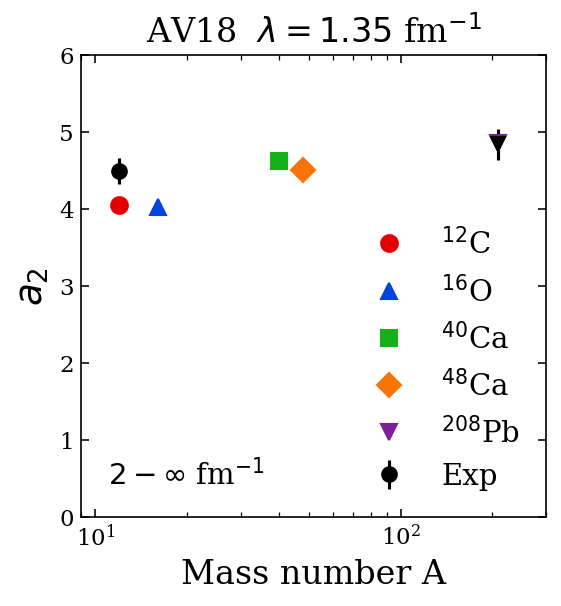

In [23]:
# # a_2 scaling factors for AV18 with \lambda=1.35 fm^-1 and S-waves only
# # Integration from 2 to \infty fm^-1

# nuclei =  ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Pb208', 82, 126) )
# channels =  ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# integration_limits = (2.0,)
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (9e0, 3e2)
# ylim = (0.0, 6.0)

# f, ax = a2_scaling_factors(nuclei, channels, kvnn, lamb, integration_limits, kmax, kmid, ntot, xlim, ylim)

# # Add legend
# legend_size = 14
# legend_location = 'lower right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Add integration limits label
# label = r'$%d-\infty$' % integration_limits[0] + ' fm' + r'$^{-1}$'
# label_location = 'lower left'
# label_size = 14
# anchored_text = AnchoredText(label, loc=label_location, prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'a2_scaling_factors'
# # Add each nucleus to file name
# for nucleus in nuclei:
#     file_name += '_%s' % nucleus[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
# # Add integration limits to file name
# file_name = file_name + '_limits_%.1f_%.1f' % (integration_limits[0], kmax)
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

12.0 4.49 0.17
208.0 4.84 0.2


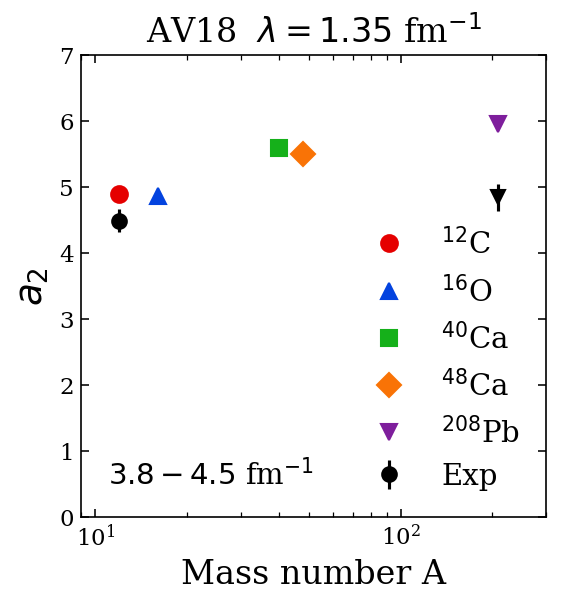

In [24]:
# # a_2 scaling factors for AV18 with \lambda=1.35 fm^-1 and S-waves only
# # Integration from 3.8 to 4.5 fm^-1

# nuclei =  ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Pb208', 82, 126) )
# channels =  ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# integration_limits = (3.8, 4.5)
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (9e0, 3e2)
# ylim = (0.0, 7.0)

# f, ax = a2_scaling_factors(nuclei, channels, kvnn, lamb, integration_limits, kmax, kmid, ntot, xlim, ylim)

# # Add legend
# legend_size = 14
# legend_location = 'lower right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 16
# ax.set_title(label, fontsize=label_size)

# # Add integration limits label
# label = r'$%.1f-%.1f$' % (integration_limits[0], integration_limits[1]) + ' fm' + r'$^{-1}$'
# label_location = 'lower left'
# label_size = 14
# anchored_text = AnchoredText(label, loc=label_location, prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'a2_scaling_factors'
# # Add each nucleus to file name
# for nucleus in nuclei:
#     file_name += '_%s' % nucleus[0]
# # Add each channel to file name
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
# # Add integration limits to file name
# file_name = file_name + '_limits_%.1f_%.1f' % (integration_limits[0], integration_limits[1])
# # Replace periods
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

__Extras__

In [25]:
# deuteron 3S1 / 3S1-3D1 ratio

In [26]:
# factorization figures

In [27]:
# nuclear contacts